### Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from random import sample
from matplotlib.cm import get_cmap
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score, classification_report, f1_score, accuracy_score

## Импортируем трейн и тест

In [2]:
train = pd.read_csv("./titanic/train.csv")

In [3]:
test = pd.read_csv("./titanic/test.csv")

## А что у нас в данных?

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


train: 
- так у нас полно пропусков в Age и Embarked, 
- посмотрим по корреляции нужно ли что то делать с другими колонками
- в принципе, можем добвить еще и титул из предыдущего урока, может быть полезно.


test:
- заполним Age, важно что *ТОЛЬКО* данными из трейна а то получится у нас утечечка данных

#### Корреляция

Изначально вот так:

In [8]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


добавим колонки на выброс(с Cabin я не согласен)

<AxesSubplot:xlabel='Survived', ylabel='Count'>

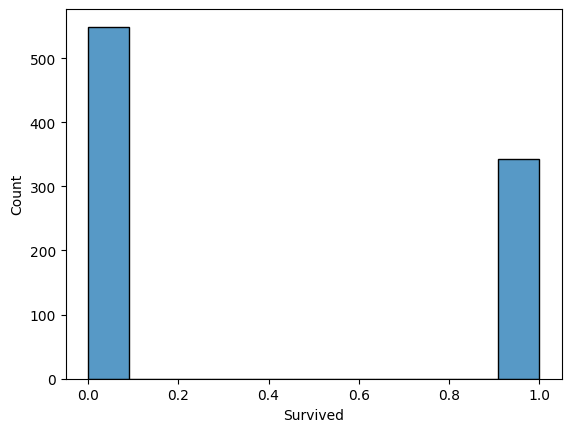

In [9]:
sns.histplot(train['Survived'])

Привет, дисбаланс классов, у нас будет хуже предсказываться 1 чем 0, 
была бы возможность разделить данные самим сделали бы стратификацию, а так будем работать с тем что есть

#### Добавляем данные и заполняем пропуски

In [10]:
def add_title(df):
    mapping = {'Don': 'RoyaltyM', 'Mme': 'Miss', 'Ms': 'Miss',
    'Major': 'Officer', 'Lady': 'RoyaltyF', 'Sir': 'RoyaltyM', 
    'Mlle': 'Miss', 'Col': 'Officer', 'Capt': 'Officer',
    'Countess': 'RoyaltyF', 'Jonkheer': 'RoyaltyM'}
    df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.')
    df.replace({'Title': mapping}, inplace=True)
    return df

In [11]:
def fill_in_age(df):
    df['Age'] = df['Age'].fillna(df.groupby('Title')['Age'].transform('median'))
    return df

In [12]:
def drop_unneeded(df):
    cols_to_drop = ['PassengerId','Name','Ticket','Cabin']
    return df.drop(cols_to_drop,axis=1)

In [13]:
def clean_embarked(df):
    max_embarked = df['Embarked'].value_counts().idxmax()
    return df.fillna(max_embarked)

In [14]:
result = pd.DataFrame(test['PassengerId'])

In [15]:
train = train.pipe(add_title).pipe(fill_in_age).pipe(drop_unneeded).pipe(clean_embarked)

In [16]:
train = train.dropna()

In [17]:
test = test.pipe(add_title).pipe(fill_in_age).pipe(drop_unneeded)

In [18]:
test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,3,male,34.5,0,0,7.8292,Q,Mr
1,3,female,47.0,1,0,7.0000,S,Mrs
2,2,male,62.0,0,0,9.6875,Q,Mr
3,3,male,27.0,0,0,8.6625,S,Mr
4,3,female,22.0,1,1,12.2875,S,Mrs
...,...,...,...,...,...,...,...,...
413,3,male,28.5,0,0,8.0500,S,Mr
414,1,female,39.0,0,0,108.9000,C,Dona
415,3,male,38.5,0,0,7.2500,S,Mr
416,3,male,28.5,0,0,8.0500,S,Mr


In [19]:
train.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.078177,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.353278,0.083081,0.018443,-0.549500
Age,-0.078177,-0.353278,1.000000,-0.264999,-0.188285,0.097675
SibSp,-0.035322,0.083081,-0.264999,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.188285,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.097675,0.159651,0.216225,1.000000


In [20]:
test.corr()

,Pclass,Age,SibSp,Parch,Fare
Pclass,1.000000,-0.470427,0.001087,0.018721,-0.577147
Age,-0.470427,1.000000,-0.086816,-0.028701,0.340561
SibSp,0.001087,-0.086816,1.000000,0.306895,0.171539
Parch,0.018721,-0.028701,0.306895,1.000000,0.230046
Fare,-0.577147,0.340561,0.171539,0.230046,1.000000


In [21]:
cats = ['Sex','Embarked','Title']

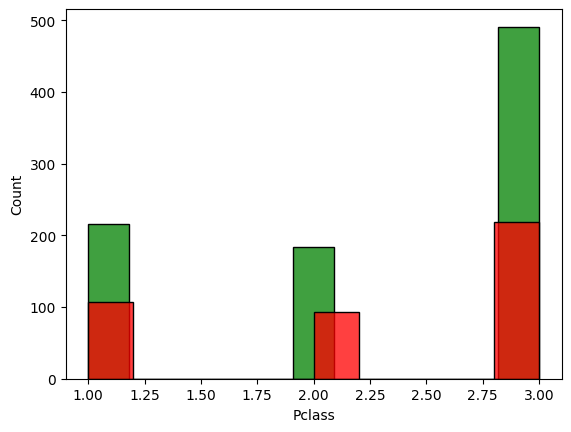

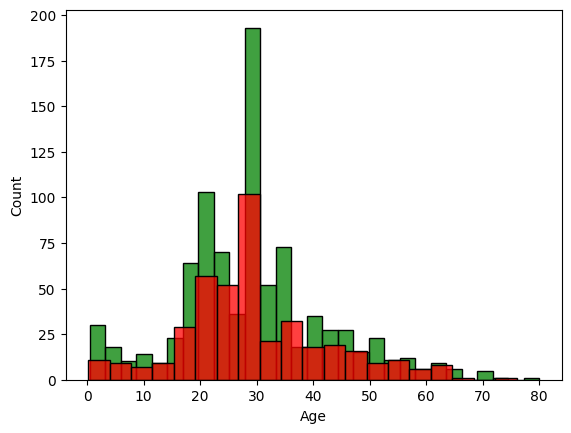

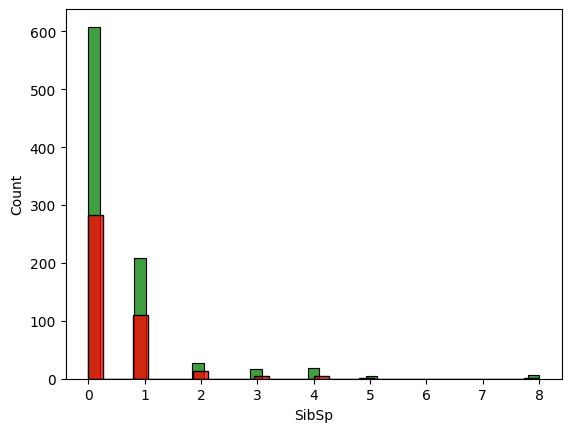

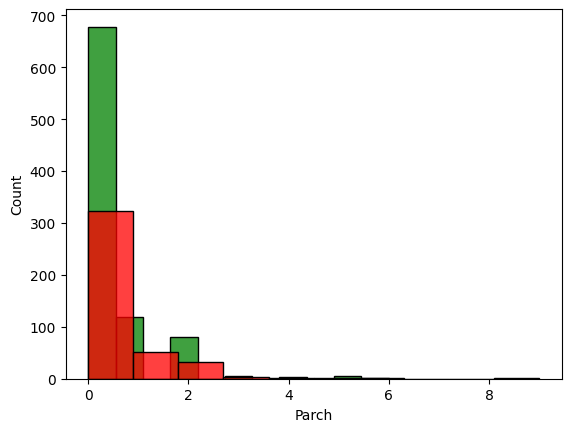

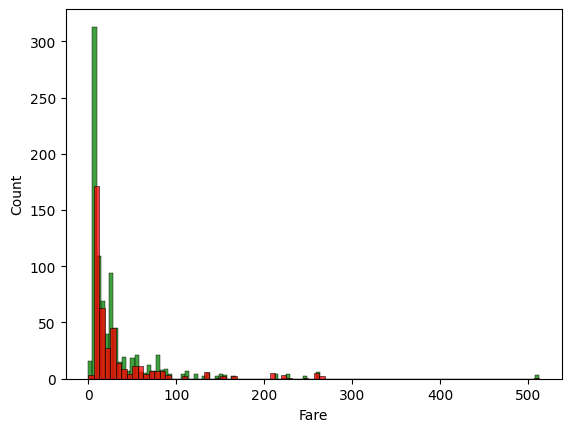

In [39]:
for c in test.drop(cats,axis=1).columns:
    sns.histplot(train[c],color='green')
    sns.histplot(test[c],color='red')
    plt.show()

Ага все нормально классы не уехали, по выборкам в этих признаках

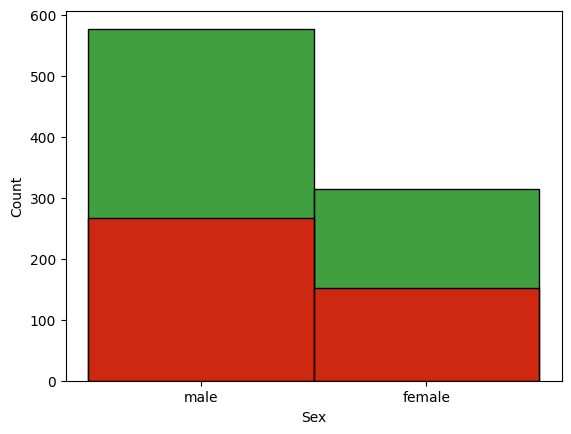

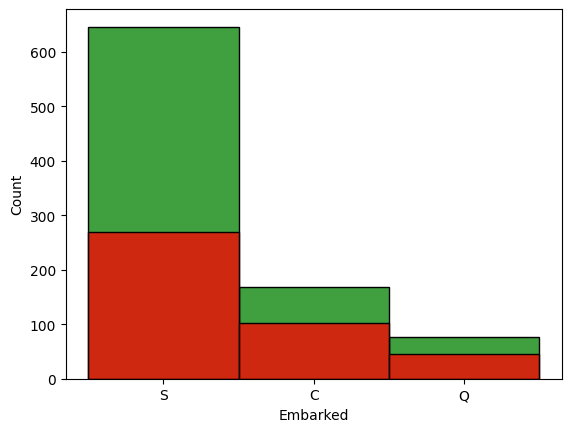

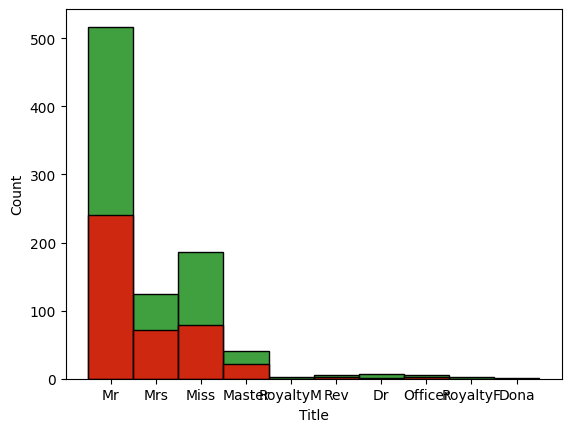

In [23]:
for c in train[cats].columns:
    p = sns.histplot(train[c],color='g')
    sns.histplot(test[c],color='r')
    plt.show()

И тут хорошо

In [40]:
train['Title'].value_counts()

Mr          517
Miss        186
Mrs         125
Master       40
Dr            7
Rev           6
Officer       5
RoyaltyM      3
RoyaltyF      2
Name: Title, dtype: int64

In [41]:
test['Title'].value_counts()

Mr         240
Miss        79
Mrs         72
Master      21
Officer      2
Rev          2
Dr           1
Dona         1
Name: Title, dtype: int64

Dona - есть только в тесте и это ломает энкодеры

### Кодирование признаков

#### попробуем энкодер - LabelEncoder

In [24]:
target_train = train['Survived']
#target_test = test['Survived']
train = train.drop('Survived',axis=1)

In [25]:
#le = LabelEncoder()

In [26]:
ohe = OneHotEncoder(drop='first',handle_unknown='ignore')

In [27]:
ohe.fit(train)

OneHotEncoder(drop='first', handle_unknown='ignore')

In [28]:
ohe_train = ohe.transform(train)

In [29]:
ohe_test = ohe.transform(test)

/Users/inenashev/Documents/Projects/tchk/lt/result_comparision/tchk_ds/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [2, 4, 5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Ага, вот тут нам энкодер как бы говорит - есть данные которых в трейне нет

In [30]:
model_rf = RandomForestClassifier(n_estimators=200)
model_kn = KNeighborsClassifier(n_neighbors=20)

In [31]:
scores = cross_val_score(model_rf, ohe_train, target_train, cv=5)
print(scores)
print(scores.mean())

scores = cross_val_score(model_kn, ohe_train, target_train, cv=5)
print(scores)
print(scores.mean())

[0.84916201 0.79775281 0.8258427  0.79213483 0.8258427 ]
0.81814700897621
[0.82681564 0.82022472 0.83146067 0.78089888 0.8258427 ]
0.817048521750047


In [32]:
model_rf = model_rf.fit(ohe_train, target_train)
predictions = model_rf.predict(ohe_test)

In [33]:
df_gs = pd.read_csv("./titanic/gender_submission.csv")

In [34]:
true_test = df_gs[df_gs['PassengerId'] == result['PassengerId']]['Survived']

In [35]:
roc_auc_score(true_test,predictions)

0.8660714285714287

In [36]:
f1_score(true_test,predictions)

0.826923076923077

In [37]:
accuracy_score(true_test,predictions)

0.8708133971291866

In [38]:
print(classification_report(true_test,predictions))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90       266
           1       0.81      0.85      0.83       152

    accuracy                           0.87       418
   macro avg       0.86      0.87      0.86       418
weighted avg       0.87      0.87      0.87       418



### Про точность

Что можно сказать, у нашей модели все не плохо, точность 0.87, f1 0.82, а ROC_AUC 0.87.

Это означает что в 87% процентах случаяев модель показывает правильные результаты, это в целом не плохо.

Однако, видно, что класс 1 то есть спавшиеся, предсказывается чуть хуже чем 0 - те кто погиб. Это вполне объяснимо, т.к. записей класса 0 больше чем 1.

Отдельно можно отметить, что данные в тесте и трейне все таки разъезжаются сильнее чем мы думали, и это однозначно влияет на точность.